In [1]:
import nest_asyncio
nest_asyncio.apply()

In [ ]:
# # Check libcudnn8 version
# !apt-cache policy libcudnn8

# # Install latest version
# # !apt install --allow-change-held-packages libcudnn8=8.4.1.50-1+cuda11.6

# # Export env variables
# !export PATH=/usr/local/cuda-11.4/bin${PATH:+:${PATH}}
# !export LD_LIBRARY_PATH=/usr/local/cuda-11.4/lib64:$LD_LIBRARY_PATH
# !export LD_LIBRARY_PATH=/usr/local/cuda-11.4/include:$LD_LIBRARY_PATH
# !export LD_LIBRARY_PATH=$LD_LIBRARY_PATH:/usr/local/cuda/extras/CUPTI/lib64

# # Install tensorflow
# !pip install tflite-model-maker==0.4.0
# !pip uninstall -y tensorflow && pip install -q tensorflow==2.9.1
# !pip install pycocotools==2.0.4
# !pip install opencv-python-headless==4.6.0.66

In [2]:
%load_ext tensorboard

In [3]:
import collections

import numpy as np
import tensorflow as tf
import tensorflow_federated as tff
import keras,os
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPool2D , Flatten
from keras.preprocessing.image import ImageDataGenerator

np.random.seed(0)

tff.federated_computation(lambda: 'Hello, World!')()

2023-02-22 19:27:01.963503: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


b'Hello, World!'

data

In [4]:
# trdata = ImageDataGenerator()
# traindata = trdata.flow_from_directory(directory="/home/train",target_size=(224,224))
# tsdata = ImageDataGenerator()
# testdata = tsdata.flow_from_directory(directory="/home/test", target_size=(224,224))
trdata = ImageDataGenerator()
traindata = trdata.flow_from_directory(directory="/home/archive/train",target_size=(64,64)) #target_size(min) = (32,32)
tsdata = ImageDataGenerator()
testdata = tsdata.flow_from_directory(directory="/home/archive/test", target_size=(64,64))

Found 82332 images belonging to 10 classes.
Found 175341 images belonging to 10 classes.


In [6]:
len(traindata)

2573

In [7]:
len(testdata)

5480

Test Model (không chạy cái này)

In [5]:
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 3)))
model.add(MaxPool2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPool2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))

-tạo model (vgg16)

In [5]:
model = Sequential()
# model.add(Conv2D(input_shape=(224,224,3),filters=64,kernel_size=(3,3),padding="same", activation="relu"))
model.add(Conv2D(input_shape=(64,64,3),filters=64,kernel_size=(3,3),padding="same", activation="relu"))
model.add(Conv2D(filters=64,kernel_size=(3,3),padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))

In [6]:
model.add(Flatten())
model.add(Dense(units=4096,activation="relu"))
model.add(Dense(units=4096,activation="relu"))
model.add(Dense(units=10, activation="softmax"))

Model gọi bằng hàm

In [3]:
model = tf.keras.applications.vgg16.VGG16(include_top=False, weights=None, input_shape=(32,32,3))

In [7]:
from keras.optimizers import Adam
opt = Adam(learning_rate=0.001)
#model.compile(optimizer=opt, loss=keras.losses.categorical_crossentropy, metrics=['accuracy'])
model.compile(optimizer=opt, 
              loss=keras.losses.categorical_crossentropy, 
              metrics=[tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), 'accuracy']
              )

In [8]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 64)        1792      
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 64)        36928     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 32, 32, 64)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 32, 32, 128)       73856     
                                                                 
 conv2d_3 (Conv2D)           (None, 32, 32, 128)       147584    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 16, 16, 128)      0         
 2D)                                                    

setup phần cứng

In [ ]:
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.compat.v1.Session(config=config)

In [8]:
gpu_options = tf.compat.v1.GPUOptions(allow_growth=True)
session = tf.compat.v1.InteractiveSession(config=tf.compat.v1.ConfigProto(gpu_options=gpu_options))

In [ ]:
physical_devices = tf.config.list_physical_devices('GPU') 
#tf.config.experimental.set_memory_growth(physical_devices[0], True)
physical_devices

In [ ]:
Train

In [9]:
from keras.callbacks import ModelCheckpoint, EarlyStopping
checkpoint = ModelCheckpoint("vgg16_1.h5", monitor='val_acc', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', save_freq=1)
early = EarlyStopping(monitor='val_acc', min_delta=0, patience=20, verbose=1, mode='auto')
with tf.device('/gpu:0'):
    hist = model.fit_generator(steps_per_epoch=100,generator=traindata, validation_data=testdata, validation_steps=100,epochs=100,callbacks=[checkpoint,early])
    #hist = model.fit(traindata, steps_per_epoch = 100, epochs=100, validation_data = testdata, callbacks=[checkpoint,early], batch_size=4)

 41/100 [===========>..................] - ETA: 5s - loss: 0.5023 - precision: 0.9060 - recall: 0.7637 - accuracy: 0.8338WARNING:tensorflow:Can save best model only with val_acc available, skipping.


 42/100 [===========>..................] - ETA: 5s - loss: 0.4995 - precision: 0.9064 - recall: 0.7634 - accuracy: 0.8341WARNING:tensorflow:Can save best model only with val_acc available, skipping.


 43/100 [===========>..................] - ETA: 5s - loss: 0.4919 - precision: 0.9086 - recall: 0.7660 - accuracy: 0.8358WARNING:tensorflow:Can save best model only with val_acc available, skipping.


 44/100 [============>.................] - ETA: 5s - loss: 0.4909 - precision: 0.9105 - recall: 0.7663 - accuracy: 0.8366WARNING:tensorflow:Can save best model only with val_acc available, skipping.


 45/100 [============>.................] - ETA: 5s - loss: 0.4982 - precision: 0.9069 - recall: 0.7646 - accuracy: 0.8347WARNING:tensorflow:Can save best model only with val_acc available, skipping.


 46/100 [============>.................] - ETA: 4s - loss: 0.4940 - precision: 0.9074 - recall: 0.7656 - accuracy: 0.8356WARNING:tensorflow:Can save best model only with val_acc available, skipping.


 47/100 [=============>................] - ETA: 4s - loss: 0.4995 - precision: 0.9062 - recall: 0.7640 - accuracy: 0.8324WARNING:tensorflow:Can save best model only with val_acc available, skipping.


 48/100 [=============>................] - ETA: 4s - loss: 0.4979 - precision: 0.9051 - recall: 0.7637 - accuracy: 0.8333WARNING:tensorflow:Can save best model only with val_acc available, skipping.


 49/100 [=============>................] - ETA: 4s - loss: 0.5069 - precision: 0.9018 - recall: 0.7615 - accuracy: 0.8304WARNING:tensorflow:Can save best model only with val_acc available, skipping.


 50/100 [==============>...............] - ETA: 4s - loss: 0.5014 - precision: 0.9038 - recall: 0.7631 - accuracy: 0.8319WARNING:tensorflow:Can save best model only with val_acc available, skipping.


 51/100 [==============>...............] - ETA: 4s - loss: 0.5110 - precision: 0.9027 - recall: 0.7616 - accuracy: 0.8297WARNING:tensorflow:Can save best model only with val_acc available, skipping.


 52/100 [==============>...............] - ETA: 4s - loss: 0.5092 - precision: 0.9032 - recall: 0.7626 - accuracy: 0.8305WARNING:tensorflow:Can save best model only with val_acc available, skipping.


 53/100 [==============>...............] - ETA: 4s - loss: 0.5070 - precision: 0.9038 - recall: 0.7642 - accuracy: 0.8314WARNING:tensorflow:Can save best model only with val_acc available, skipping.


 54/100 [===============>..............] - ETA: 4s - loss: 0.5039 - precision: 0.9049 - recall: 0.7656 - accuracy: 0.8322WARNING:tensorflow:Can save best model only with val_acc available, skipping.


 55/100 [===============>..............] - ETA: 4s - loss: 0.5018 - precision: 0.9041 - recall: 0.7659 - accuracy: 0.8330WARNING:tensorflow:Can save best model only with val_acc available, skipping.


 56/100 [===============>..............] - ETA: 4s - loss: 0.5033 - precision: 0.9050 - recall: 0.7656 - accuracy: 0.8320WARNING:tensorflow:Can save best model only with val_acc available, skipping.


 57/100 [================>.............] - ETA: 3s - loss: 0.4997 - precision: 0.9056 - recall: 0.7675 - accuracy: 0.8333WARNING:tensorflow:Can save best model only with val_acc available, skipping.


 58/100 [================>.............] - ETA: 3s - loss: 0.4971 - precision: 0.9053 - recall: 0.7678 - accuracy: 0.8330WARNING:tensorflow:Can save best model only with val_acc available, skipping.


 59/100 [================>.............] - ETA: 3s - loss: 0.4962 - precision: 0.9062 - recall: 0.7680 - accuracy: 0.8332WARNING:tensorflow:Can save best model only with val_acc available, skipping.


 60/100 [=================>............] - ETA: 3s - loss: 0.4978 - precision: 0.9065 - recall: 0.7677 - accuracy: 0.8333WARNING:tensorflow:Can save best model only with val_acc available, skipping.


 61/100 [=================>............] - ETA: 3s - loss: 0.4965 - precision: 0.9068 - recall: 0.7679 - accuracy: 0.8335WARNING:tensorflow:Can save best model only with val_acc available, skipping.


 62/100 [=================>............] - ETA: 3s - loss: 0.4925 - precision: 0.9073 - recall: 0.7692 - accuracy: 0.8342WARNING:tensorflow:Can save best model only with val_acc available, skipping.


 63/100 [=================>............] - ETA: 3s - loss: 0.4897 - precision: 0.9076 - recall: 0.7698 - accuracy: 0.8343WARNING:tensorflow:Can save best model only with val_acc available, skipping.


 64/100 [==================>...........] - ETA: 3s - loss: 0.4901 - precision: 0.9057 - recall: 0.7690 - accuracy: 0.8335WARNING:tensorflow:Can save best model only with val_acc available, skipping.


 65/100 [==================>...........] - ETA: 3s - loss: 0.4911 - precision: 0.9050 - recall: 0.7697 - accuracy: 0.8341WARNING:tensorflow:Can save best model only with val_acc available, skipping.


 66/100 [==================>...........] - ETA: 3s - loss: 0.4904 - precision: 0.9054 - recall: 0.7704 - accuracy: 0.8348WARNING:tensorflow:Can save best model only with val_acc available, skipping.


 67/100 [===================>..........] - ETA: 3s - loss: 0.4917 - precision: 0.9052 - recall: 0.7701 - accuracy: 0.8349WARNING:tensorflow:Can save best model only with val_acc available, skipping.


 68/100 [===================>..........] - ETA: 2s - loss: 0.4960 - precision: 0.9048 - recall: 0.7684 - accuracy: 0.8332WARNING:tensorflow:Can save best model only with val_acc available, skipping.


 69/100 [===================>..........] - ETA: 2s - loss: 0.4933 - precision: 0.9056 - recall: 0.7690 - accuracy: 0.8329WARNING:tensorflow:Can save best model only with val_acc available, skipping.


 70/100 [====================>.........] - ETA: 2s - loss: 0.4914 - precision: 0.9065 - recall: 0.7701 - accuracy: 0.8330WARNING:tensorflow:Can save best model only with val_acc available, skipping.


 71/100 [====================>.........] - ETA: 2s - loss: 0.4909 - precision: 0.9067 - recall: 0.7702 - accuracy: 0.8327WARNING:tensorflow:Can save best model only with val_acc available, skipping.


 72/100 [====================>.........] - ETA: 2s - loss: 0.4902 - precision: 0.9076 - recall: 0.7713 - accuracy: 0.8333WARNING:tensorflow:Can save best model only with val_acc available, skipping.


 73/100 [====================>.........] - ETA: 2s - loss: 0.4870 - precision: 0.9088 - recall: 0.7718 - accuracy: 0.8335WARNING:tensorflow:Can save best model only with val_acc available, skipping.


 74/100 [=====================>........] - ETA: 2s - loss: 0.4910 - precision: 0.9071 - recall: 0.7707 - accuracy: 0.8328WARNING:tensorflow:Can save best model only with val_acc available, skipping.


 75/100 [=====================>........] - ETA: 2s - loss: 0.4877 - precision: 0.9079 - recall: 0.7721 - accuracy: 0.8342WARNING:tensorflow:Can save best model only with val_acc available, skipping.


 76/100 [=====================>........] - ETA: 2s - loss: 0.4868 - precision: 0.9085 - recall: 0.7718 - accuracy: 0.8347WARNING:tensorflow:Can save best model only with val_acc available, skipping.


 77/100 [======================>.......] - ETA: 2s - loss: 0.4844 - precision: 0.9096 - recall: 0.7719 - accuracy: 0.8352WARNING:tensorflow:Can save best model only with val_acc available, skipping.


 78/100 [======================>.......] - ETA: 2s - loss: 0.4863 - precision: 0.9096 - recall: 0.7704 - accuracy: 0.8349WARNING:tensorflow:Can save best model only with val_acc available, skipping.


 79/100 [======================>.......] - ETA: 1s - loss: 0.4847 - precision: 0.9099 - recall: 0.7710 - accuracy: 0.8354WARNING:tensorflow:Can save best model only with val_acc available, skipping.


 80/100 [=======================>......] - ETA: 1s - loss: 0.4890 - precision: 0.9087 - recall: 0.7699 - accuracy: 0.8348WARNING:tensorflow:Can save best model only with val_acc available, skipping.


 81/100 [=======================>......] - ETA: 1s - loss: 0.4900 - precision: 0.9089 - recall: 0.7697 - accuracy: 0.8341WARNING:tensorflow:Can save best model only with val_acc available, skipping.


 82/100 [=======================>......] - ETA: 1s - loss: 0.4882 - precision: 0.9092 - recall: 0.7706 - accuracy: 0.8342WARNING:tensorflow:Can save best model only with val_acc available, skipping.


 83/100 [=======================>......] - ETA: 1s - loss: 0.4885 - precision: 0.9093 - recall: 0.7700 - accuracy: 0.8340WARNING:tensorflow:Can save best model only with val_acc available, skipping.


 84/100 [========================>.....] - ETA: 1s - loss: 0.4909 - precision: 0.9077 - recall: 0.7686 - accuracy: 0.8333WARNING:tensorflow:Can save best model only with val_acc available, skipping.


 85/100 [========================>.....] - ETA: 1s - loss: 0.4922 - precision: 0.9074 - recall: 0.7676 - accuracy: 0.8324WARNING:tensorflow:Can save best model only with val_acc available, skipping.


 86/100 [========================>.....] - ETA: 1s - loss: 0.4921 - precision: 0.9072 - recall: 0.7674 - accuracy: 0.8318WARNING:tensorflow:Can save best model only with val_acc available, skipping.


 87/100 [=========================>....] - ETA: 1s - loss: 0.4918 - precision: 0.9074 - recall: 0.7672 - accuracy: 0.8319WARNING:tensorflow:Can save best model only with val_acc available, skipping.


 88/100 [=========================>....] - ETA: 1s - loss: 0.4909 - precision: 0.9075 - recall: 0.7667 - accuracy: 0.8317WARNING:tensorflow:Can save best model only with val_acc available, skipping.


 89/100 [=========================>....] - ETA: 1s - loss: 0.4924 - precision: 0.9076 - recall: 0.7654 - accuracy: 0.8308WARNING:tensorflow:Can save best model only with val_acc available, skipping.


 90/100 [==========================>...] - ETA: 0s - loss: 0.4923 - precision: 0.9084 - recall: 0.7646 - accuracy: 0.8316WARNING:tensorflow:Can save best model only with val_acc available, skipping.


 91/100 [==========================>...] - ETA: 0s - loss: 0.4902 - precision: 0.9083 - recall: 0.7655 - accuracy: 0.8321WARNING:tensorflow:Can save best model only with val_acc available, skipping.


 92/100 [==========================>...] - ETA: 0s - loss: 0.4883 - precision: 0.9086 - recall: 0.7666 - accuracy: 0.8329WARNING:tensorflow:Can save best model only with val_acc available, skipping.


 93/100 [==========================>...] - ETA: 0s - loss: 0.4876 - precision: 0.9088 - recall: 0.7665 - accuracy: 0.8327WARNING:tensorflow:Can save best model only with val_acc available, skipping.


 94/100 [===========================>..] - ETA: 0s - loss: 0.4898 - precision: 0.9078 - recall: 0.7656 - accuracy: 0.8314WARNING:tensorflow:Can save best model only with val_acc available, skipping.


 95/100 [===========================>..] - ETA: 0s - loss: 0.4903 - precision: 0.9079 - recall: 0.7651 - accuracy: 0.8309WARNING:tensorflow:Can save best model only with val_acc available, skipping.


 96/100 [===========================>..] - ETA: 0s - loss: 0.4932 - precision: 0.9066 - recall: 0.7646 - accuracy: 0.8298WARNING:tensorflow:Can save best model only with val_acc available, skipping.


 97/100 [============================>.] - ETA: 0s - loss: 0.4927 - precision: 0.9068 - recall: 0.7648 - accuracy: 0.8296WARNING:tensorflow:Can save best model only with val_acc available, skipping.


 98/100 [============================>.] - ETA: 0s - loss: 0.4913 - precision: 0.9067 - recall: 0.7653 - accuracy: 0.8297WARNING:tensorflow:Can save best model only with val_acc available, skipping.


 99/100 [============================>.] - ETA: 0s - loss: 0.4898 - precision: 0.9073 - recall: 0.7664 - accuracy: 0.8305WARNING:tensorflow:Can save best model only with val_acc available, skipping.


100/100 [==============================] - ETA: 0s - loss: 0.4887 - precision: 0.9073 - recall: 0.7675 - accuracy: 0.8309WARNING:tensorflow:Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,precision,recall,accuracy,val_loss,val_precision,val_recall,val_accuracy


100/100 [==============================] - 12s 120ms/step - loss: 0.4887 - precision: 0.9073 - recall: 0.7675 - accuracy: 0.8309 - val_loss: 0.9670 - val_precision: 0.8229 - val_recall: 0.6591 - val_accuracy: 0.7328
Epoch 99/100


  1/100 [..............................] - ETA: 11s - loss: 0.3460 - precision: 0.8966 - recall: 0.8125 - accuracy: 0.8438WARNING:tensorflow:Can save best model only with val_acc available, skipping.


  2/100 [..............................] - ETA: 9s - loss: 0.2994 - precision: 0.9444 - recall: 0.7969 - accuracy: 0.8750 WARNING:tensorflow:Can save best model only with val_acc available, skipping.


  3/100 [..............................] - ETA: 8s - loss: 0.4661 - precision: 0.9211 - recall: 0.7292 - accuracy: 0.8229WARNING:tensorflow:Can save best model only with val_acc available, skipping.


  4/100 [>.............................] - ETA: 8s - loss: 0.5369 - precision: 0.9029 - recall: 0.7266 - accuracy: 0.8047WARNING:tensorflow:Can save best model only with val_acc available, skipping.


  5/100 [>.............................] - ETA: 8s - loss: 0.5314 - precision: 0.9084 - recall: 0.7437 - accuracy: 0.8125WARNING:tensorflow:Can save best model only with val_acc available, skipping.


  6/100 [>.............................] - ETA: 8s - loss: 0.5341 - precision: 0.9097 - recall: 0.7344 - accuracy: 0.8177WARNING:tensorflow:Can save best model only with val_acc available, skipping.


  7/100 [=>............................] - ETA: 8s - loss: 0.5165 - precision: 0.9130 - recall: 0.7500 - accuracy: 0.8304WARNING:tensorflow:Can save best model only with val_acc available, skipping.


  8/100 [=>............................] - ETA: 8s - loss: 0.5052 - precision: 0.9095 - recall: 0.7461 - accuracy: 0.8242WARNING:tensorflow:Can save best model only with val_acc available, skipping.


  9/100 [=>............................] - ETA: 8s - loss: 0.5080 - precision: 0.9064 - recall: 0.7396 - accuracy: 0.8194WARNING:tensorflow:Can save best model only with val_acc available, skipping.


 10/100 [==>...........................] - ETA: 8s - loss: 0.5004 - precision: 0.9049 - recall: 0.7437 - accuracy: 0.8250WARNING:tensorflow:Can save best model only with val_acc available, skipping.


 11/100 [==>...........................] - ETA: 8s - loss: 0.5122 - precision: 0.9021 - recall: 0.7330 - accuracy: 0.8182WARNING:tensorflow:Can save best model only with val_acc available, skipping.


 12/100 [==>...........................] - ETA: 8s - loss: 0.5121 - precision: 0.8949 - recall: 0.7318 - accuracy: 0.8203WARNING:tensorflow:Can save best model only with val_acc available, skipping.


 13/100 [==>...........................] - ETA: 7s - loss: 0.5133 - precision: 0.8994 - recall: 0.7308 - accuracy: 0.8221WARNING:tensorflow:Can save best model only with val_acc available, skipping.


 14/100 [===>..........................] - ETA: 7s - loss: 0.5039 - precision: 0.9008 - recall: 0.7299 - accuracy: 0.8237WARNING:tensorflow:Can save best model only with val_acc available, skipping.


 15/100 [===>..........................] - ETA: 7s - loss: 0.5008 - precision: 0.9000 - recall: 0.7312 - accuracy: 0.8208WARNING:tensorflow:Can save best model only with val_acc available, skipping.


 16/100 [===>..........................] - ETA: 7s - loss: 0.4966 - precision: 0.9038 - recall: 0.7344 - accuracy: 0.8223WARNING:tensorflow:Can save best model only with val_acc available, skipping.


 17/100 [====>.........................] - ETA: 7s - loss: 0.4863 - precision: 0.9052 - recall: 0.7371 - accuracy: 0.8235WARNING:tensorflow:Can save best model only with val_acc available, skipping.


 18/100 [====>.........................] - ETA: 7s - loss: 0.4820 - precision: 0.9064 - recall: 0.7396 - accuracy: 0.8229WARNING:tensorflow:Can save best model only with val_acc available, skipping.


 19/100 [====>.........................] - ETA: 7s - loss: 0.5001 - precision: 0.9049 - recall: 0.7352 - accuracy: 0.8191WARNING:tensorflow:Can save best model only with val_acc available, skipping.


 20/100 [=====>........................] - ETA: 7s - loss: 0.5089 - precision: 0.9073 - recall: 0.7344 - accuracy: 0.8172WARNING:tensorflow:Can save best model only with val_acc available, skipping.


 21/100 [=====>........................] - ETA: 7s - loss: 0.5024 - precision: 0.9098 - recall: 0.7351 - accuracy: 0.8170WARNING:tensorflow:Can save best model only with val_acc available, skipping.


 22/100 [=====>........................] - ETA: 7s - loss: 0.4921 - precision: 0.9140 - recall: 0.7401 - accuracy: 0.8182WARNING:tensorflow:Can save best model only with val_acc available, skipping.


 23/100 [=====>........................] - ETA: 7s - loss: 0.5083 - precision: 0.9067 - recall: 0.7391 - accuracy: 0.8152WARNING:tensorflow:Can save best model only with val_acc available, skipping.


 24/100 [======>.......................] - ETA: 6s - loss: 0.5079 - precision: 0.9087 - recall: 0.7383 - accuracy: 0.8138WARNING:tensorflow:Can save best model only with val_acc available, skipping.


 25/100 [======>.......................] - ETA: 6s - loss: 0.4969 - precision: 0.9122 - recall: 0.7400 - accuracy: 0.8200WARNING:tensorflow:Can save best model only with val_acc available, skipping.


 26/100 [======>.......................] - ETA: 6s - loss: 0.4924 - precision: 0.9154 - recall: 0.7416 - accuracy: 0.8209WARNING:tensorflow:Can save best model only with val_acc available, skipping.


 27/100 [=======>......................] - ETA: 6s - loss: 0.4956 - precision: 0.9168 - recall: 0.7396 - accuracy: 0.8171WARNING:tensorflow:Can save best model only with val_acc available, skipping.


 28/100 [=======>......................] - ETA: 6s - loss: 0.4924 - precision: 0.9174 - recall: 0.7433 - accuracy: 0.8181WARNING:tensorflow:Can save best model only with val_acc available, skipping.


 29/100 [=======>......................] - ETA: 6s - loss: 0.4958 - precision: 0.9148 - recall: 0.7403 - accuracy: 0.8168WARNING:tensorflow:Can save best model only with val_acc available, skipping.


 30/100 [========>.....................] - ETA: 6s - loss: 0.4986 - precision: 0.9137 - recall: 0.7385 - accuracy: 0.8146WARNING:tensorflow:Can save best model only with val_acc available, skipping.


 31/100 [========>.....................] - ETA: 6s - loss: 0.4973 - precision: 0.9139 - recall: 0.7379 - accuracy: 0.8125WARNING:tensorflow:Can save best model only with val_acc available, skipping.


 32/100 [========>.....................] - ETA: 6s - loss: 0.4968 - precision: 0.9119 - recall: 0.7383 - accuracy: 0.8125WARNING:tensorflow:Can save best model only with val_acc available, skipping.


 33/100 [========>.....................] - ETA: 6s - loss: 0.4925 - precision: 0.9124 - recall: 0.7396 - accuracy: 0.8134WARNING:tensorflow:Can save best model only with val_acc available, skipping.


 34/100 [=========>....................] - ETA: 6s - loss: 0.4900 - precision: 0.9120 - recall: 0.7426 - accuracy: 0.8143WARNING:tensorflow:Can save best model only with val_acc available, skipping.


 35/100 [=========>....................] - ETA: 5s - loss: 0.4908 - precision: 0.9124 - recall: 0.7437 - accuracy: 0.8152WARNING:tensorflow:Can save best model only with val_acc available, skipping.


 36/100 [=========>....................] - ETA: 5s - loss: 0.4865 - precision: 0.9129 - recall: 0.7457 - accuracy: 0.8160WARNING:tensorflow:Can save best model only with val_acc available, skipping.


 37/100 [==========>...................] - ETA: 5s - loss: 0.4839 - precision: 0.9134 - recall: 0.7483 - accuracy: 0.8184WARNING:tensorflow:Can save best model only with val_acc available, skipping.


 38/100 [==========>...................] - ETA: 5s - loss: 0.4822 - precision: 0.9129 - recall: 0.7500 - accuracy: 0.8199WARNING:tensorflow:Can save best model only with val_acc available, skipping.


 39/100 [==========>...................] - ETA: 5s - loss: 0.4802 - precision: 0.9125 - recall: 0.7516 - accuracy: 0.8221WARNING:tensorflow:Can save best model only with val_acc available, skipping.


 40/100 [===========>..................] - ETA: 5s - loss: 0.4779 - precision: 0.9120 - recall: 0.7531 - accuracy: 0.8219WARNING:tensorflow:Can save best model only with val_acc available, skipping.


 41/100 [===========>..................] - ETA: 5s - loss: 0.4708 - precision: 0.9144 - recall: 0.7569 - accuracy: 0.8255WARNING:tensorflow:Can save best model only with val_acc available, skipping.


 42/100 [===========>..................] - ETA: 5s - loss: 0.4669 - precision: 0.9155 - recall: 0.7582 - accuracy: 0.8274WARNING:tensorflow:Can save best model only with val_acc available, skipping.


 43/100 [===========>..................] - ETA: 5s - loss: 0.4665 - precision: 0.9140 - recall: 0.7573 - accuracy: 0.8263WARNING:tensorflow:Can save best model only with val_acc available, skipping.


 44/100 [============>.................] - ETA: 5s - loss: 0.4745 - precision: 0.9117 - recall: 0.7557 - accuracy: 0.8246WARNING:tensorflow:Can save best model only with val_acc available, skipping.


 45/100 [============>.................] - ETA: 5s - loss: 0.4734 - precision: 0.9098 - recall: 0.7563 - accuracy: 0.8243WARNING:tensorflow:Can save best model only with val_acc available, skipping.


 46/100 [============>.................] - ETA: 4s - loss: 0.4782 - precision: 0.9083 - recall: 0.7541 - accuracy: 0.8220WARNING:tensorflow:Can save best model only with val_acc available, skipping.


 47/100 [=============>................] - ETA: 4s - loss: 0.4760 - precision: 0.9087 - recall: 0.7547 - accuracy: 0.8225WARNING:tensorflow:Can save best model only with val_acc available, skipping.


 48/100 [=============>................] - ETA: 4s - loss: 0.4734 - precision: 0.9084 - recall: 0.7552 - accuracy: 0.8236WARNING:tensorflow:Can save best model only with val_acc available, skipping.


 49/100 [=============>................] - ETA: 4s - loss: 0.4785 - precision: 0.9057 - recall: 0.7532 - accuracy: 0.8208WARNING:tensorflow:Can save best model only with val_acc available, skipping.


 50/100 [==============>...............] - ETA: 4s - loss: 0.4784 - precision: 0.9053 - recall: 0.7531 - accuracy: 0.8206WARNING:tensorflow:Can save best model only with val_acc available, skipping.


 51/100 [==============>...............] - ETA: 4s - loss: 0.4783 - precision: 0.9060 - recall: 0.7561 - accuracy: 0.8223WARNING:tensorflow:Can save best model only with val_acc available, skipping.


 52/100 [==============>...............] - ETA: 4s - loss: 0.4738 - precision: 0.9079 - recall: 0.7584 - accuracy: 0.8239WARNING:tensorflow:Can save best model only with val_acc available, skipping.


 53/100 [==============>...............] - ETA: 4s - loss: 0.4689 - precision: 0.9091 - recall: 0.7606 - accuracy: 0.8255WARNING:tensorflow:Can save best model only with val_acc available, skipping.


 54/100 [===============>..............] - ETA: 4s - loss: 0.4728 - precision: 0.9087 - recall: 0.7598 - accuracy: 0.8241WARNING:tensorflow:Can save best model only with val_acc available, skipping.


 55/100 [===============>..............] - ETA: 4s - loss: 0.4719 - precision: 0.9096 - recall: 0.7602 - accuracy: 0.8233WARNING:tensorflow:Can save best model only with val_acc available, skipping.


 56/100 [===============>..............] - ETA: 4s - loss: 0.4692 - precision: 0.9107 - recall: 0.7623 - accuracy: 0.8248WARNING:tensorflow:Can save best model only with val_acc available, skipping.


 57/100 [================>.............] - ETA: 3s - loss: 0.4670 - precision: 0.9122 - recall: 0.7632 - accuracy: 0.8257WARNING:tensorflow:Can save best model only with val_acc available, skipping.


 58/100 [================>.............] - ETA: 3s - loss: 0.4711 - precision: 0.9121 - recall: 0.7608 - accuracy: 0.8233WARNING:tensorflow:Can save best model only with val_acc available, skipping.


 59/100 [================>.............] - ETA: 3s - loss: 0.4689 - precision: 0.9131 - recall: 0.7622 - accuracy: 0.8236WARNING:tensorflow:Can save best model only with val_acc available, skipping.


 60/100 [=================>............] - ETA: 3s - loss: 0.4657 - precision: 0.9145 - recall: 0.7630 - accuracy: 0.8234WARNING:tensorflow:Can save best model only with val_acc available, skipping.


 61/100 [=================>............] - ETA: 3s - loss: 0.4641 - precision: 0.9142 - recall: 0.7638 - accuracy: 0.8243WARNING:tensorflow:Can save best model only with val_acc available, skipping.


 62/100 [=================>............] - ETA: 3s - loss: 0.4601 - precision: 0.9150 - recall: 0.7646 - accuracy: 0.8251WARNING:tensorflow:Can save best model only with val_acc available, skipping.


 63/100 [=================>............] - ETA: 3s - loss: 0.4603 - precision: 0.9151 - recall: 0.7649 - accuracy: 0.8249WARNING:tensorflow:Can save best model only with val_acc available, skipping.


 64/100 [==================>...........] - ETA: 3s - loss: 0.4566 - precision: 0.9159 - recall: 0.7656 - accuracy: 0.8271WARNING:tensorflow:Can save best model only with val_acc available, skipping.


 65/100 [==================>...........] - ETA: 3s - loss: 0.4510 - precision: 0.9174 - recall: 0.7688 - accuracy: 0.8293WARNING:tensorflow:Can save best model only with val_acc available, skipping.


 66/100 [==================>...........] - ETA: 3s - loss: 0.4542 - precision: 0.9163 - recall: 0.7675 - accuracy: 0.8286WARNING:tensorflow:Can save best model only with val_acc available, skipping.


 67/100 [===================>..........] - ETA: 3s - loss: 0.4513 - precision: 0.9166 - recall: 0.7687 - accuracy: 0.8293WARNING:tensorflow:Can save best model only with val_acc available, skipping.


 68/100 [===================>..........] - ETA: 2s - loss: 0.4499 - precision: 0.9173 - recall: 0.7693 - accuracy: 0.8290WARNING:tensorflow:Can save best model only with val_acc available, skipping.


 69/100 [===================>..........] - ETA: 2s - loss: 0.4486 - precision: 0.9169 - recall: 0.7695 - accuracy: 0.8293WARNING:tensorflow:Can save best model only with val_acc available, skipping.


 70/100 [====================>.........] - ETA: 2s - loss: 0.4515 - precision: 0.9159 - recall: 0.7683 - accuracy: 0.8281WARNING:tensorflow:Can save best model only with val_acc available, skipping.


 71/100 [====================>.........] - ETA: 2s - loss: 0.4548 - precision: 0.9149 - recall: 0.7667 - accuracy: 0.8270WARNING:tensorflow:Can save best model only with val_acc available, skipping.


 72/100 [====================>.........] - ETA: 2s - loss: 0.4541 - precision: 0.9155 - recall: 0.7669 - accuracy: 0.8277WARNING:tensorflow:Can save best model only with val_acc available, skipping.


 73/100 [====================>.........] - ETA: 2s - loss: 0.4569 - precision: 0.9141 - recall: 0.7654 - accuracy: 0.8266WARNING:tensorflow:Can save best model only with val_acc available, skipping.


 74/100 [=====================>........] - ETA: 2s - loss: 0.4540 - precision: 0.9139 - recall: 0.7669 - accuracy: 0.8277WARNING:tensorflow:Can save best model only with val_acc available, skipping.


 75/100 [=====================>........] - ETA: 2s - loss: 0.4563 - precision: 0.9140 - recall: 0.7658 - accuracy: 0.8258WARNING:tensorflow:Can save best model only with val_acc available, skipping.


 76/100 [=====================>........] - ETA: 2s - loss: 0.4548 - precision: 0.9142 - recall: 0.7669 - accuracy: 0.8265WARNING:tensorflow:Can save best model only with val_acc available, skipping.


 77/100 [======================>.......] - ETA: 2s - loss: 0.4577 - precision: 0.9134 - recall: 0.7658 - accuracy: 0.8247WARNING:tensorflow:Can save best model only with val_acc available, skipping.


 78/100 [======================>.......] - ETA: 2s - loss: 0.4572 - precision: 0.9140 - recall: 0.7664 - accuracy: 0.8249WARNING:tensorflow:Can save best model only with val_acc available, skipping.


 79/100 [======================>.......] - ETA: 1s - loss: 0.4535 - precision: 0.9143 - recall: 0.7678 - accuracy: 0.8263WARNING:tensorflow:Can save best model only with val_acc available, skipping.


 80/100 [=======================>......] - ETA: 1s - loss: 0.4559 - precision: 0.9134 - recall: 0.7668 - accuracy: 0.8258WARNING:tensorflow:Can save best model only with val_acc available, skipping.


 81/100 [=======================>......] - ETA: 1s - loss: 0.4555 - precision: 0.9132 - recall: 0.7674 - accuracy: 0.8256WARNING:tensorflow:Can save best model only with val_acc available, skipping.


 82/100 [=======================>......] - ETA: 1s - loss: 0.4543 - precision: 0.9130 - recall: 0.7679 - accuracy: 0.8258WARNING:tensorflow:Can save best model only with val_acc available, skipping.


 83/100 [=======================>......] - ETA: 1s - loss: 0.4556 - precision: 0.9123 - recall: 0.7677 - accuracy: 0.8257WARNING:tensorflow:Can save best model only with val_acc available, skipping.


 84/100 [========================>.....] - ETA: 1s - loss: 0.4551 - precision: 0.9124 - recall: 0.7675 - accuracy: 0.8259WARNING:tensorflow:Can save best model only with val_acc available, skipping.


 85/100 [========================>.....] - ETA: 1s - loss: 0.4577 - precision: 0.9114 - recall: 0.7673 - accuracy: 0.8250WARNING:tensorflow:Can save best model only with val_acc available, skipping.


 86/100 [========================>.....] - ETA: 1s - loss: 0.4590 - precision: 0.9114 - recall: 0.7667 - accuracy: 0.8238WARNING:tensorflow:Can save best model only with val_acc available, skipping.


 87/100 [=========================>....] - ETA: 1s - loss: 0.4582 - precision: 0.9115 - recall: 0.7662 - accuracy: 0.8236WARNING:tensorflow:Can save best model only with val_acc available, skipping.


 88/100 [=========================>....] - ETA: 1s - loss: 0.4564 - precision: 0.9122 - recall: 0.7670 - accuracy: 0.8246WARNING:tensorflow:Can save best model only with val_acc available, skipping.


 89/100 [=========================>....] - ETA: 1s - loss: 0.4573 - precision: 0.9122 - recall: 0.7662 - accuracy: 0.8234WARNING:tensorflow:Can save best model only with val_acc available, skipping.


 90/100 [==========================>...] - ETA: 0s - loss: 0.4573 - precision: 0.9124 - recall: 0.7667 - accuracy: 0.8240WARNING:tensorflow:Can save best model only with val_acc available, skipping.


 91/100 [==========================>...] - ETA: 0s - loss: 0.4550 - precision: 0.9130 - recall: 0.7679 - accuracy: 0.8252WARNING:tensorflow:Can save best model only with val_acc available, skipping.


 92/100 [==========================>...] - ETA: 0s - loss: 0.4542 - precision: 0.9136 - recall: 0.7683 - accuracy: 0.8254WARNING:tensorflow:Can save best model only with val_acc available, skipping.


 93/100 [==========================>...] - ETA: 0s - loss: 0.4534 - precision: 0.9137 - recall: 0.7688 - accuracy: 0.8253WARNING:tensorflow:Can save best model only with val_acc available, skipping.


 94/100 [===========================>..] - ETA: 0s - loss: 0.4529 - precision: 0.9143 - recall: 0.7696 - accuracy: 0.8255WARNING:tensorflow:Can save best model only with val_acc available, skipping.


 95/100 [===========================>..] - ETA: 0s - loss: 0.4547 - precision: 0.9144 - recall: 0.7691 - accuracy: 0.8253WARNING:tensorflow:Can save best model only with val_acc available, skipping.


 96/100 [===========================>..] - ETA: 0s - loss: 0.4559 - precision: 0.9141 - recall: 0.7689 - accuracy: 0.8252WARNING:tensorflow:Can save best model only with val_acc available, skipping.


 97/100 [============================>.] - ETA: 0s - loss: 0.4598 - precision: 0.9133 - recall: 0.7674 - accuracy: 0.8238WARNING:tensorflow:Can save best model only with val_acc available, skipping.


 98/100 [============================>.] - ETA: 0s - loss: 0.4590 - precision: 0.9142 - recall: 0.7679 - accuracy: 0.8243WARNING:tensorflow:Can save best model only with val_acc available, skipping.


 99/100 [============================>.] - ETA: 0s - loss: 0.4581 - precision: 0.9140 - recall: 0.7683 - accuracy: 0.8242WARNING:tensorflow:Can save best model only with val_acc available, skipping.


100/100 [==============================] - ETA: 0s - loss: 0.4571 - precision: 0.9138 - recall: 0.7684 - accuracy: 0.8247WARNING:tensorflow:Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,precision,recall,accuracy,val_loss,val_precision,val_recall,val_accuracy


100/100 [==============================] - 12s 119ms/step - loss: 0.4571 - precision: 0.9138 - recall: 0.7684 - accuracy: 0.8247 - val_loss: 1.0564 - val_precision: 0.8107 - val_recall: 0.6450 - val_accuracy: 0.7312
Epoch 100/100


  1/100 [..............................] - ETA: 11s - loss: 0.3742 - precision: 0.9583 - recall: 0.7188 - accuracy: 0.7500WARNING:tensorflow:Can save best model only with val_acc available, skipping.


  2/100 [..............................] - ETA: 9s - loss: 0.4390 - precision: 0.9020 - recall: 0.7188 - accuracy: 0.7812 WARNING:tensorflow:Can save best model only with val_acc available, skipping.


  3/100 [..............................] - ETA: 8s - loss: 0.4506 - precision: 0.9324 - recall: 0.7188 - accuracy: 0.7917WARNING:tensorflow:Can save best model only with val_acc available, skipping.


  4/100 [>.............................] - ETA: 8s - loss: 0.4270 - precision: 0.9307 - recall: 0.7344 - accuracy: 0.8281WARNING:tensorflow:Can save best model only with val_acc available, skipping.


  5/100 [>.............................] - ETA: 8s - loss: 0.4279 - precision: 0.9302 - recall: 0.7500 - accuracy: 0.8438WARNING:tensorflow:Can save best model only with val_acc available, skipping.


  6/100 [>.............................] - ETA: 8s - loss: 0.4891 - precision: 0.9272 - recall: 0.7292 - accuracy: 0.8125WARNING:tensorflow:Can save best model only with val_acc available, skipping.


  7/100 [=>............................] - ETA: 8s - loss: 0.5081 - precision: 0.9213 - recall: 0.7321 - accuracy: 0.8080WARNING:tensorflow:Can save best model only with val_acc available, skipping.


  8/100 [=>............................] - ETA: 8s - loss: 0.5713 - precision: 0.9104 - recall: 0.7148 - accuracy: 0.7852WARNING:tensorflow:Can save best model only with val_acc available, skipping.


  9/100 [=>............................] - ETA: 8s - loss: 0.5644 - precision: 0.9035 - recall: 0.7153 - accuracy: 0.7847WARNING:tensorflow:Can save best model only with val_acc available, skipping.


 10/100 [==>...........................] - ETA: 8s - loss: 0.5473 - precision: 0.9055 - recall: 0.7188 - accuracy: 0.7906WARNING:tensorflow:Can save best model only with val_acc available, skipping.


 11/100 [==>...........................] - ETA: 8s - loss: 0.5363 - precision: 0.9043 - recall: 0.7244 - accuracy: 0.7983WARNING:tensorflow:Can save best model only with val_acc available, skipping.


 12/100 [==>...........................] - ETA: 8s - loss: 0.5197 - precision: 0.9097 - recall: 0.7344 - accuracy: 0.8073WARNING:tensorflow:Can save best model only with val_acc available, skipping.


 13/100 [==>...........................] - ETA: 7s - loss: 0.5194 - precision: 0.9048 - recall: 0.7308 - accuracy: 0.8077WARNING:tensorflow:Can save best model only with val_acc available, skipping.


 14/100 [===>..........................] - ETA: 7s - loss: 0.5254 - precision: 0.9058 - recall: 0.7299 - accuracy: 0.8080WARNING:tensorflow:Can save best model only with val_acc available, skipping.


 15/100 [===>..........................] - ETA: 7s - loss: 0.5199 - precision: 0.9044 - recall: 0.7292 - accuracy: 0.8062WARNING:tensorflow:Can save best model only with val_acc available, skipping.


 16/100 [===>..........................] - ETA: 7s - loss: 0.5238 - precision: 0.9056 - recall: 0.7305 - accuracy: 0.8047WARNING:tensorflow:Can save best model only with val_acc available, skipping.


 17/100 [====>.........................] - ETA: 7s - loss: 0.5250 - precision: 0.9045 - recall: 0.7316 - accuracy: 0.8070WARNING:tensorflow:Can save best model only with val_acc available, skipping.


 18/100 [====>.........................] - ETA: 7s - loss: 0.5215 - precision: 0.9038 - recall: 0.7344 - accuracy: 0.8090WARNING:tensorflow:Can save best model only with val_acc available, skipping.


 19/100 [====>.........................] - ETA: 7s - loss: 0.5246 - precision: 0.9030 - recall: 0.7352 - accuracy: 0.8092WARNING:tensorflow:Can save best model only with val_acc available, skipping.


 20/100 [=====>........................] - ETA: 7s - loss: 0.5094 - precision: 0.9082 - recall: 0.7422 - accuracy: 0.8141WARNING:tensorflow:Can save best model only with val_acc available, skipping.


 21/100 [=====>........................] - ETA: 7s - loss: 0.5104 - precision: 0.9088 - recall: 0.7411 - accuracy: 0.8155WARNING:tensorflow:Can save best model only with val_acc available, skipping.


 22/100 [=====>........................] - ETA: 7s - loss: 0.5114 - precision: 0.9059 - recall: 0.7386 - accuracy: 0.8139WARNING:tensorflow:Can save best model only with val_acc available, skipping.


 23/100 [=====>........................] - ETA: 7s - loss: 0.5037 - precision: 0.9070 - recall: 0.7418 - accuracy: 0.8139WARNING:tensorflow:Can save best model only with val_acc available, skipping.


 24/100 [======>.......................] - ETA: 6s - loss: 0.5029 - precision: 0.9091 - recall: 0.7422 - accuracy: 0.8151WARNING:tensorflow:Can save best model only with val_acc available, skipping.


 25/100 [======>.......................] - ETA: 6s - loss: 0.4959 - precision: 0.9128 - recall: 0.7462 - accuracy: 0.8188WARNING:tensorflow:Can save best model only with val_acc available, skipping.


 26/100 [======>.......................] - ETA: 6s - loss: 0.4944 - precision: 0.9116 - recall: 0.7440 - accuracy: 0.8185WARNING:tensorflow:Can save best model only with val_acc available, skipping.


 27/100 [=======>......................] - ETA: 6s - loss: 0.4882 - precision: 0.9124 - recall: 0.7477 - accuracy: 0.8206WARNING:tensorflow:Can save best model only with val_acc available, skipping.


 28/100 [=======>......................] - ETA: 6s - loss: 0.4903 - precision: 0.9100 - recall: 0.7444 - accuracy: 0.8203WARNING:tensorflow:Can save best model only with val_acc available, skipping.


 29/100 [=======>......................] - ETA: 6s - loss: 0.4933 - precision: 0.9089 - recall: 0.7414 - accuracy: 0.8190WARNING:tensorflow:Can save best model only with val_acc available, skipping.


 30/100 [========>.....................] - ETA: 6s - loss: 0.4916 - precision: 0.9085 - recall: 0.7448 - accuracy: 0.8198WARNING:tensorflow:Can save best model only with val_acc available, skipping.


 31/100 [========>.....................] - ETA: 6s - loss: 0.4949 - precision: 0.9065 - recall: 0.7429 - accuracy: 0.8155WARNING:tensorflow:Can save best model only with val_acc available, skipping.


 32/100 [========>.....................] - ETA: 6s - loss: 0.4982 - precision: 0.9051 - recall: 0.7451 - accuracy: 0.8164WARNING:tensorflow:Can save best model only with val_acc available, skipping.


 33/100 [========>.....................] - ETA: 6s - loss: 0.4995 - precision: 0.9025 - recall: 0.7453 - accuracy: 0.8163WARNING:tensorflow:Can save best model only with val_acc available, skipping.


 34/100 [=========>....................] - ETA: 6s - loss: 0.5001 - precision: 0.9012 - recall: 0.7463 - accuracy: 0.8153WARNING:tensorflow:Can save best model only with val_acc available, skipping.


 35/100 [=========>....................] - ETA: 5s - loss: 0.4979 - precision: 0.9019 - recall: 0.7473 - accuracy: 0.8152WARNING:tensorflow:Can save best model only with val_acc available, skipping.


 36/100 [=========>....................] - ETA: 5s - loss: 0.4931 - precision: 0.9027 - recall: 0.7491 - accuracy: 0.8160WARNING:tensorflow:Can save best model only with val_acc available, skipping.


 37/100 [==========>...................] - ETA: 5s - loss: 0.4897 - precision: 0.9036 - recall: 0.7517 - accuracy: 0.8176WARNING:tensorflow:Can save best model only with val_acc available, skipping.


 38/100 [==========>...................] - ETA: 5s - loss: 0.4870 - precision: 0.9025 - recall: 0.7533 - accuracy: 0.8183WARNING:tensorflow:Can save best model only with val_acc available, skipping.


 39/100 [==========>...................] - ETA: 5s - loss: 0.4865 - precision: 0.9005 - recall: 0.7540 - accuracy: 0.8173WARNING:tensorflow:Can save best model only with val_acc available, skipping.


 40/100 [===========>..................] - ETA: 5s - loss: 0.4869 - precision: 0.9003 - recall: 0.7547 - accuracy: 0.8172WARNING:tensorflow:Can save best model only with val_acc available, skipping.


 41/100 [===========>..................] - ETA: 5s - loss: 0.4883 - precision: 0.9010 - recall: 0.7561 - accuracy: 0.8178WARNING:tensorflow:Can save best model only with val_acc available, skipping.


 42/100 [===========>..................] - ETA: 5s - loss: 0.4838 - precision: 0.9018 - recall: 0.7582 - accuracy: 0.8192WARNING:tensorflow:Can save best model only with val_acc available, skipping.


 43/100 [===========>..................] - ETA: 5s - loss: 0.4842 - precision: 0.9006 - recall: 0.7573 - accuracy: 0.8176WARNING:tensorflow:Can save best model only with val_acc available, skipping.


 44/100 [============>.................] - ETA: 5s - loss: 0.4818 - precision: 0.9021 - recall: 0.7592 - accuracy: 0.8182WARNING:tensorflow:Can save best model only with val_acc available, skipping.


 45/100 [============>.................] - ETA: 5s - loss: 0.4793 - precision: 0.9013 - recall: 0.7611 - accuracy: 0.8188WARNING:tensorflow:Can save best model only with val_acc available, skipping.


 46/100 [============>.................] - ETA: 4s - loss: 0.4763 - precision: 0.9020 - recall: 0.7629 - accuracy: 0.8193WARNING:tensorflow:Can save best model only with val_acc available, skipping.


 47/100 [=============>................] - ETA: 4s - loss: 0.4780 - precision: 0.9024 - recall: 0.7626 - accuracy: 0.8191WARNING:tensorflow:Can save best model only with val_acc available, skipping.


 48/100 [=============>................] - ETA: 4s - loss: 0.4760 - precision: 0.9029 - recall: 0.7630 - accuracy: 0.8203WARNING:tensorflow:Can save best model only with val_acc available, skipping.


 49/100 [=============>................] - ETA: 4s - loss: 0.4941 - precision: 0.9003 - recall: 0.7602 - accuracy: 0.8176WARNING:tensorflow:Can save best model only with val_acc available, skipping.


 50/100 [==============>...............] - ETA: 4s - loss: 0.4950 - precision: 0.9012 - recall: 0.7581 - accuracy: 0.8169WARNING:tensorflow:Can save best model only with val_acc available, skipping.


 51/100 [==============>...............] - ETA: 4s - loss: 0.4979 - precision: 0.9008 - recall: 0.7567 - accuracy: 0.8156WARNING:tensorflow:Can save best model only with val_acc available, skipping.


 52/100 [==============>...............] - ETA: 4s - loss: 0.4954 - precision: 0.9014 - recall: 0.7578 - accuracy: 0.8155WARNING:tensorflow:Can save best model only with val_acc available, skipping.


 53/100 [==============>...............] - ETA: 4s - loss: 0.5026 - precision: 0.9013 - recall: 0.7541 - accuracy: 0.8131WARNING:tensorflow:Can save best model only with val_acc available, skipping.


 54/100 [===============>..............] - ETA: 4s - loss: 0.5116 - precision: 0.8994 - recall: 0.7506 - accuracy: 0.8113WARNING:tensorflow:Can save best model only with val_acc available, skipping.


 55/100 [===============>..............] - ETA: 4s - loss: 0.5115 - precision: 0.8984 - recall: 0.7489 - accuracy: 0.8102WARNING:tensorflow:Can save best model only with val_acc available, skipping.


 56/100 [===============>..............] - ETA: 4s - loss: 0.5202 - precision: 0.8967 - recall: 0.7461 - accuracy: 0.8080WARNING:tensorflow:Can save best model only with val_acc available, skipping.


 57/100 [================>.............] - ETA: 3s - loss: 0.5296 - precision: 0.8940 - recall: 0.7401 - accuracy: 0.8059WARNING:tensorflow:Can save best model only with val_acc available, skipping.


 58/100 [================>.............] - ETA: 3s - loss: 0.5335 - precision: 0.8941 - recall: 0.7371 - accuracy: 0.8060WARNING:tensorflow:Can save best model only with val_acc available, skipping.


 59/100 [================>.............] - ETA: 3s - loss: 0.5357 - precision: 0.8945 - recall: 0.7362 - accuracy: 0.8056WARNING:tensorflow:Can save best model only with val_acc available, skipping.


 60/100 [=================>............] - ETA: 3s - loss: 0.5394 - precision: 0.8930 - recall: 0.7344 - accuracy: 0.8042WARNING:tensorflow:Can save best model only with val_acc available, skipping.


 61/100 [=================>............] - ETA: 3s - loss: 0.5411 - precision: 0.8933 - recall: 0.7336 - accuracy: 0.8038WARNING:tensorflow:Can save best model only with val_acc available, skipping.


 62/100 [=================>............] - ETA: 3s - loss: 0.5496 - precision: 0.8918 - recall: 0.7314 - accuracy: 0.8014WARNING:tensorflow:Can save best model only with val_acc available, skipping.


 63/100 [=================>............] - ETA: 3s - loss: 0.5503 - precision: 0.8916 - recall: 0.7302 - accuracy: 0.8016WARNING:tensorflow:Can save best model only with val_acc available, skipping.


 64/100 [==================>...........] - ETA: 3s - loss: 0.5534 - precision: 0.8910 - recall: 0.7305 - accuracy: 0.8008WARNING:tensorflow:Can save best model only with val_acc available, skipping.


 65/100 [==================>...........] - ETA: 3s - loss: 0.5524 - precision: 0.8908 - recall: 0.7298 - accuracy: 0.8014WARNING:tensorflow:Can save best model only with val_acc available, skipping.


 66/100 [==================>...........] - ETA: 3s - loss: 0.5476 - precision: 0.8922 - recall: 0.7325 - accuracy: 0.8035WARNING:tensorflow:Can save best model only with val_acc available, skipping.


 67/100 [===================>..........] - ETA: 3s - loss: 0.5518 - precision: 0.8910 - recall: 0.7323 - accuracy: 0.8027WARNING:tensorflow:Can save best model only with val_acc available, skipping.


 68/100 [===================>..........] - ETA: 2s - loss: 0.5574 - precision: 0.8899 - recall: 0.7316 - accuracy: 0.8019WARNING:tensorflow:Can save best model only with val_acc available, skipping.


 69/100 [===================>..........] - ETA: 2s - loss: 0.5566 - precision: 0.8900 - recall: 0.7328 - accuracy: 0.8034WARNING:tensorflow:Can save best model only with val_acc available, skipping.


 70/100 [====================>.........] - ETA: 2s - loss: 0.5527 - precision: 0.8912 - recall: 0.7353 - accuracy: 0.8049WARNING:tensorflow:Can save best model only with val_acc available, skipping.


 71/100 [====================>.........] - ETA: 2s - loss: 0.5571 - precision: 0.8900 - recall: 0.7333 - accuracy: 0.8028WARNING:tensorflow:Can save best model only with val_acc available, skipping.


 72/100 [====================>.........] - ETA: 2s - loss: 0.5576 - precision: 0.8895 - recall: 0.7339 - accuracy: 0.8025WARNING:tensorflow:Can save best model only with val_acc available, skipping.


 73/100 [====================>.........] - ETA: 2s - loss: 0.5576 - precision: 0.8892 - recall: 0.7350 - accuracy: 0.8027WARNING:tensorflow:Can save best model only with val_acc available, skipping.


 74/100 [=====================>........] - ETA: 2s - loss: 0.5541 - precision: 0.8904 - recall: 0.7373 - accuracy: 0.8041WARNING:tensorflow:Can save best model only with val_acc available, skipping.


 75/100 [=====================>........] - ETA: 2s - loss: 0.5535 - precision: 0.8903 - recall: 0.7375 - accuracy: 0.8037WARNING:tensorflow:Can save best model only with val_acc available, skipping.


 76/100 [=====================>........] - ETA: 2s - loss: 0.5540 - precision: 0.8904 - recall: 0.7381 - accuracy: 0.8043WARNING:tensorflow:Can save best model only with val_acc available, skipping.


 77/100 [======================>.......] - ETA: 2s - loss: 0.5547 - precision: 0.8899 - recall: 0.7382 - accuracy: 0.8036WARNING:tensorflow:Can save best model only with val_acc available, skipping.


 78/100 [======================>.......] - ETA: 2s - loss: 0.5545 - precision: 0.8907 - recall: 0.7380 - accuracy: 0.8037WARNING:tensorflow:Can save best model only with val_acc available, skipping.


 79/100 [======================>.......] - ETA: 1s - loss: 0.5576 - precision: 0.8900 - recall: 0.7358 - accuracy: 0.8030WARNING:tensorflow:Can save best model only with val_acc available, skipping.


 80/100 [=======================>......] - ETA: 1s - loss: 0.5607 - precision: 0.8884 - recall: 0.7340 - accuracy: 0.8020WARNING:tensorflow:Can save best model only with val_acc available, skipping.


 81/100 [=======================>......] - ETA: 1s - loss: 0.5610 - precision: 0.8895 - recall: 0.7326 - accuracy: 0.8013WARNING:tensorflow:Can save best model only with val_acc available, skipping.


 82/100 [=======================>......] - ETA: 1s - loss: 0.5610 - precision: 0.8898 - recall: 0.7321 - accuracy: 0.8003WARNING:tensorflow:Can save best model only with val_acc available, skipping.


 83/100 [=======================>......] - ETA: 1s - loss: 0.5619 - precision: 0.8896 - recall: 0.7312 - accuracy: 0.7997WARNING:tensorflow:Can save best model only with val_acc available, skipping.


 84/100 [========================>.....] - ETA: 1s - loss: 0.5595 - precision: 0.8904 - recall: 0.7318 - accuracy: 0.8010WARNING:tensorflow:Can save best model only with val_acc available, skipping.


 85/100 [========================>.....] - ETA: 1s - loss: 0.5600 - precision: 0.8910 - recall: 0.7305 - accuracy: 0.8015WARNING:tensorflow:Can save best model only with val_acc available, skipping.


 86/100 [========================>.....] - ETA: 1s - loss: 0.5588 - precision: 0.8910 - recall: 0.7304 - accuracy: 0.8020WARNING:tensorflow:Can save best model only with val_acc available, skipping.


 87/100 [=========================>....] - ETA: 1s - loss: 0.5586 - precision: 0.8904 - recall: 0.7295 - accuracy: 0.8010WARNING:tensorflow:Can save best model only with val_acc available, skipping.


 88/100 [=========================>....] - ETA: 1s - loss: 0.5565 - precision: 0.8904 - recall: 0.7298 - accuracy: 0.8008WARNING:tensorflow:Can save best model only with val_acc available, skipping.


 89/100 [=========================>....] - ETA: 1s - loss: 0.5555 - precision: 0.8915 - recall: 0.7296 - accuracy: 0.8006WARNING:tensorflow:Can save best model only with val_acc available, skipping.


 90/100 [==========================>...] - ETA: 0s - loss: 0.5559 - precision: 0.8917 - recall: 0.7292 - accuracy: 0.8003WARNING:tensorflow:Can save best model only with val_acc available, skipping.


 91/100 [==========================>...] - ETA: 0s - loss: 0.5554 - precision: 0.8920 - recall: 0.7291 - accuracy: 0.8008WARNING:tensorflow:Can save best model only with val_acc available, skipping.


 92/100 [==========================>...] - ETA: 0s - loss: 0.5575 - precision: 0.8905 - recall: 0.7293 - accuracy: 0.8003WARNING:tensorflow:Can save best model only with val_acc available, skipping.


 93/100 [==========================>...] - ETA: 0s - loss: 0.5544 - precision: 0.8913 - recall: 0.7298 - accuracy: 0.8011WARNING:tensorflow:Can save best model only with val_acc available, skipping.


 94/100 [===========================>..] - ETA: 0s - loss: 0.5516 - precision: 0.8920 - recall: 0.7304 - accuracy: 0.8022WARNING:tensorflow:Can save best model only with val_acc available, skipping.


 95/100 [===========================>..] - ETA: 0s - loss: 0.5558 - precision: 0.8911 - recall: 0.7296 - accuracy: 0.8013WARNING:tensorflow:Can save best model only with val_acc available, skipping.


 96/100 [===========================>..] - ETA: 0s - loss: 0.5534 - precision: 0.8915 - recall: 0.7305 - accuracy: 0.8018WARNING:tensorflow:Can save best model only with val_acc available, skipping.


 97/100 [============================>.] - ETA: 0s - loss: 0.5500 - precision: 0.8923 - recall: 0.7313 - accuracy: 0.8025WARNING:tensorflow:Can save best model only with val_acc available, skipping.


 98/100 [============================>.] - ETA: 0s - loss: 0.5481 - precision: 0.8921 - recall: 0.7328 - accuracy: 0.8033WARNING:tensorflow:Can save best model only with val_acc available, skipping.


 99/100 [============================>.] - ETA: 0s - loss: 0.5463 - precision: 0.8914 - recall: 0.7333 - accuracy: 0.8033WARNING:tensorflow:Can save best model only with val_acc available, skipping.


100/100 [==============================] - ETA: 0s - loss: 0.5478 - precision: 0.8904 - recall: 0.7334 - accuracy: 0.8031WARNING:tensorflow:Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,precision,recall,accuracy,val_loss,val_precision,val_recall,val_accuracy


100/100 [==============================] - 12s 121ms/step - loss: 0.5478 - precision: 0.8904 - recall: 0.7334 - accuracy: 0.8031 - val_loss: 1.2640 - val_precision: 0.7702 - val_recall: 0.6294 - val_accuracy: 0.6966


lưu model

In [10]:
#!mkdir saved_models
#model.save('home/saved_models/100e32x32vgg16') 
model.save('home/saved_models/100e64x64vgg16') 

INFO:tensorflow:Assets written to: home/saved_models/100e64x64vgg16/assets


INFO:tensorflow:Assets written to: home/saved_models/100e64x64vgg16/assets


biểu đồ

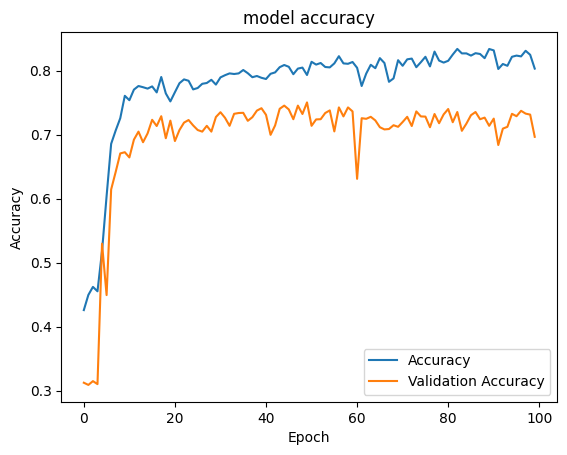

In [11]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(hist.history["accuracy"])
plt.plot(hist.history['val_accuracy'])
#plt.plot(hist.history['val_loss'])
plt.title("model accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(["Accuracy","Validation Accuracy"])
plt.savefig('/home/foo1.png', bbox_inches='tight')
plt.show()


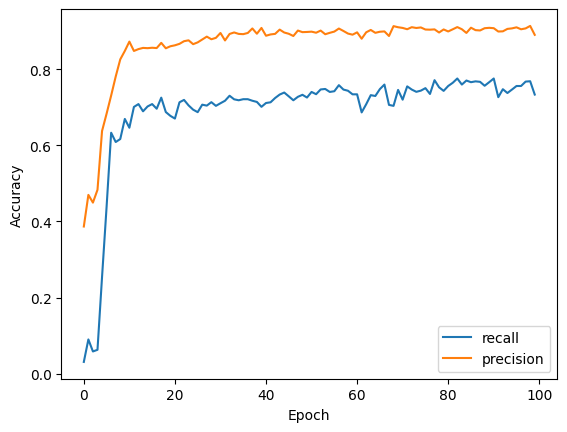

In [12]:
plt.plot(hist.history['recall'])
plt.plot(hist.history['precision'])

plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(["recall","precision"])
plt.savefig('/home/foo2.png', bbox_inches='tight')
plt.show()


In [15]:
import numpy
pre = hist.history['precision']
rc = hist.history['recall']
arrPre = numpy.array(pre)
arrRc = numpy.array(rc)
#f1 = 2*(pre * rc)/(re + rc)
print(pre)
print(rc)
#print(f1)

[0.38671875, 0.4698205590248108, 0.44951921701431274, 0.48317307233810425, 0.6376470327377319, 0.6832116842269897, 0.7308802604675293, 0.7807615399360657, 0.825868546962738, 0.8479809761047363, 0.8725738525390625, 0.8480151295661926, 0.8528969287872314, 0.8560341596603394, 0.8553482890129089, 0.8564412593841553, 0.855606734752655, 0.8692883849143982, 0.8550330400466919, 0.8603174686431885, 0.8628318309783936, 0.8666920065879822, 0.8736242651939392, 0.8759720325469971, 0.865834653377533, 0.8705463409423828, 0.8781055808067322, 0.8856581449508667, 0.8787528872489929, 0.8824451565742493, 0.8952755928039551, 0.8756200075149536, 0.8926661610603333, 0.8966187238693237, 0.8928155303001404, 0.8921530842781067, 0.8952676653862, 0.9071146249771118, 0.8932759761810303, 0.9085020422935486, 0.8880218267440796, 0.891406238079071, 0.8929121494293213, 0.9040831923484802, 0.8964732885360718, 0.8931443691253662, 0.8873022198677063, 0.9016266465187073, 0.8974359035491943, 0.8979118466377258, 0.8987101912

In [16]:
acc = numpy.array(hist.history["accuracy"])
valacc = numpy.array(hist.history['val_accuracy'])
print(acc)
print(valacc)

[0.4259375  0.44968751 0.4621875  0.45531249 0.518125   0.6040625
 0.68562502 0.70656252 0.72562498 0.760625   0.75375003 0.77031249
 0.7759375  0.77406251 0.77187502 0.77531248 0.76593751 0.79000002
 0.76437497 0.75187498 0.76625001 0.78031248 0.78625    0.78410512
 0.770625   0.77281249 0.77937502 0.78062499 0.78562498 0.77812499
 0.78937501 0.79281253 0.79562497 0.79468751 0.79562497 0.80093747
 0.79593748 0.78968751 0.7915625  0.78874999 0.78687501 0.79500002
 0.79718751 0.80531251 0.80874997 0.80593753 0.794375   0.80312502
 0.8046875  0.79312497 0.81375003 0.80937499 0.81187499 0.80562502
 0.80500001 0.81124997 0.82249999 0.81124997 0.81062502 0.81343752
 0.80437499 0.7759375  0.79531252 0.80906248 0.80374998 0.81946182
 0.81187499 0.78250003 0.78781247 0.81625003 0.8075     0.81758446
 0.81875002 0.80531251 0.81312501 0.82156253 0.80656248 0.82968748
 0.81562501 0.8125     0.8153125  0.82499999 0.83385479 0.82687497
 0.82687497 0.82343751 0.82718748 0.82593751 0.81937498 0.83375

: 

In [12]:
import numpy
pre = hist.history['precision']
rc = hist.history['recall']
arrPre = numpy.array(pre)
arrRc = numpy.array(rc)
#f1 = 2*(pre * rc)/(re + rc)
print(pre)
print(rc)
#print(f1)

[0.4152046740055084, 0.5108024477958679, 0.7344827651977539, 0.8482598662376404, 0.8236009478569031, 0.8419941067695618, 0.8459349870681763, 0.8347613215446472, 0.8535911440849304, 0.8464462161064148, 0.8622258901596069, 0.8581209778785706, 0.849056601524353, 0.8368247151374817, 0.8593811392784119, 0.8392782211303711, 0.8516369462013245, 0.8403722047805786, 0.8428842425346375, 0.8514370918273926, 0.856351375579834, 0.8562596440315247, 0.8465887904167175, 0.8489425778388977, 0.8454720377922058, 0.8520485758781433, 0.8520126342773438, 0.8522984385490417, 0.859096109867096, 0.8553127646446228, 0.8532832860946655, 0.838145911693573, 0.8542846441268921, 0.8507853150367737, 0.8591337203979492, 0.8561013340950012, 0.854586124420166, 0.8467532396316528, 0.8547423481941223, 0.8593812584877014, 0.8504083156585693, 0.8546661734580994, 0.8496296405792236, 0.8622121810913086, 0.8566080331802368, 0.8656156063079834, 0.8796935081481934, 0.8600460290908813, 0.8748037815093994, 0.8673431277275085, 0.86